In [1]:
import ROOT as rt

Welcome to JupyROOT 6.28/00


In [2]:
# load_path = "workspace/workspace_ggh_All_Zfit_no_e_cut_UL_calib_cat5.root"
load_path = "workspace/workspace_ggh_All_Zfit_no_e_cut_UL_calib_cat5_data_x.root"

In [3]:
file = rt.TFile.Open(load_path)

In [4]:
canvas = rt.TCanvas()
canvas.cd()
mass =  rt.RooRealVar("mh_ggh","mass (GeV)",100,85,99)
# mass.setBins(100) # bin to 100 bins otherwise, fitting with FFT conv is gonna take forever
mass.setBins(10000) # stress test
frame = mass.frame()

In [5]:
bwWidth = rt.RooRealVar("bwz_Width" , "widthZ", 2.5, 0, 30)
bwmZ = rt.RooRealVar("bwz_mZ" , "mZ", 91.2, 90, 92)
sigma = rt.RooRealVar("sigma" , "sigma", 2, 0.0, 5.0)

bwWidth.setConstant(True)
bwmZ.setConstant(True) # set bwmZ 

model1_1 = rt.RooBreitWigner("bwz", "BWZ",mass, bwmZ, bwWidth)

"""
Note from Jan: sometimes freeze n values in DCB to be frozen (ie 1, but could be other values)
This is because alpha and n are highly correlated, so roofit can be really confused.
Also, given that we care about the resolution, not the actual parameter values alpha and n, we can 
put whatevere restrictions we want.
"""
mean = rt.RooRealVar("mean" , "mean", 0, -10,10) # mean is mean relative to BW
sigma = rt.RooRealVar("sigma" , "sigma", 2, .1, 4.0)
alpha1 = rt.RooRealVar("alpha1" , "alpha1", 2, 0.01, 65)
n1 = rt.RooRealVar("n1" , "n1", 10, 0.01, 185)
alpha2 = rt.RooRealVar("alpha2" , "alpha2", 2.0, 0.01, 65)
n2 = rt.RooRealVar("n2" , "n2", 25, 0.01, 385)
n1.setConstant(True)
n2.setConstant(True)
model1_2 = rt.RooCrystalBall("dcb","dcb",mass, mean, sigma, alpha1, n1, alpha2, n2)

model1 = rt.RooFFTConvPdf("BWxDCB", "BWxDCB", mass, model1_1, model1_2)


mass.setBins(10000,"cache") # cache is repre of the varibale only used in FFT


mass.setMin("cache",50.5) 
mass.setMax("cache",130.5)

coeff = rt.RooRealVar("coeff", "coeff", -0.01, -1, -0.00000001)
# shift = rt.RooRealVar("shift" , "shift", 92, -10, 1000)
# coeff = rt.RooRealVar("coeff", "Slope", 0.0001, -1.5, 0)
shift = rt.RooRealVar("shift", "Offset", 85, 75, 105)
shifted_mass = rt.RooFormulaVar("shifted_mass", "@0-@1", rt.RooArgList(mass, shift))
model2 = rt.RooExponential("Exponential", "Exponential", shifted_mass, coeff)

sigfrac = rt.RooRealVar("sigfrac", "sigfrac", 0.98, 0, 1.0)
model3 = rt.RooAddPdf("model3", "model3", rt.RooArgList(model1, model2),sigfrac)

[#0] ERROR:Caching -- The internal binning of variable mh_ggh is not uniform. The numerical FFT will likely yield wrong results.


In [6]:
import time

start = time.time()

#fitting directly to unbinned dataset is slow, so first make a histogram
roo_dataset = file.w.data("data_Zfit_no_e_cut_UL_calib_cat5")
data_hist = rt.RooDataHist("data_hist","binned version of roo_dataset", rt.RooArgSet(mass), roo_dataset)  # copies binning from mass variable
# model1.fitTo(data_hist) 
# model3.fitTo(data_hist, Minos=True) 
# model3.fitTo(data_hist) 

# cuda tetsing
# rt.EnableImplicitMT()
# model3.fitTo(data_hist, rt.RooFit.BatchMode("cpu"))
model3.fitTo(data_hist) 


end = time.time()
print(f"fitting elapsed time: {end - start}")

fitting elapsed time: 7.452550888061523
[#1] INFO:Eval -- RooRealVar::setRange(mh_ggh) new range named 'refrange_fft_BWxDCB' created with bounds [50.5,130.5]
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(BWxDCB) creating new cache 0x55e907824e30 with pdf bwz_CONV_dcb_CACHE_Obs[mh_ggh]_NORM_mh_ggh for nset (mh_ggh) with code 0
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bwz_CONV_dcb_CACHE_Obs[mh_ggh]_NORM_mh_ggh_Int[mh_ggh]) using numeric integrator RooIntegrator1D to calculate Int(mh_ggh)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(Exponential_Int[mh_ggh]) using numeric integrator RooIntegrator1D to calculate Int(mh_ggh)
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(BWxDCB) creating new cache 0x55e907c0a640 with pdf bwz_CONV_dcb_CACHE_Obs[mh_ggh]_NORM_mh_ggh for nset (mh_ggh) with code 0 from preexisting content.
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bwz_C

[#1] INFO:Caching -- RooAbsCachedPdf::getCache(BWxDCB) creating new cache 0x55e90798c970 with pdf bwz_CONV_dcb_CACHE_Obs[mh_ggh]_NORM_mh_ggh for nset (mh_ggh) with code 0
[#1] INFO:NumericIntegration -- RooRealIntegral::init(bwz_CONV_dcb_CACHE_Obs[mh_ggh]_NORM_mh_ggh_Int[mh_ggh]) using numeric integrator RooIntegrator1D to calculate Int(mh_ggh)
[#1] INFO:NumericIntegration -- RooRealIntegral::init(Exponential_Int[mh_ggh]) using numeric integrator RooIntegrator1D to calculate Int(mh_ggh)


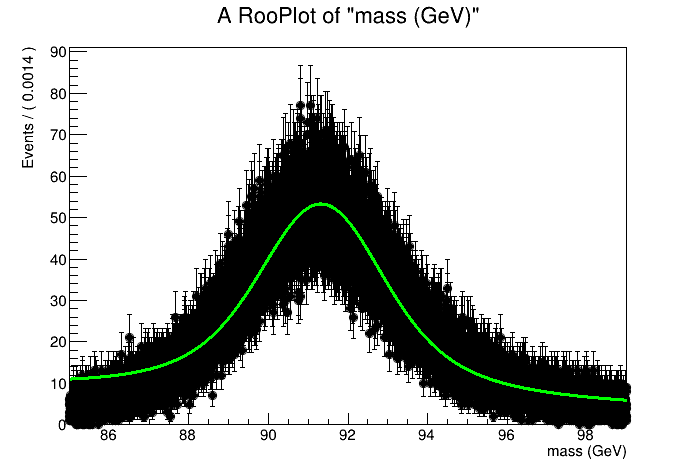

In [7]:
# file.w.pdf("Voigtian_ggh_All").plotOn(frame)
file.w.data("data_Zfit_no_e_cut_UL_calib_cat5").plotOn(frame)
# model3.plotOn(frame, rt.RooFit.LineColor(rt.kGreen))
# model1.plotOn(frame, rt.RooFit.LineColor(rt.kRed))
# model2.plotOn(frame, rt.RooFit.LineColor(rt.kBlue))
# model1_1.plotOn(frame, rt.RooFit.LineColor(rt.kRed))
# model1_2.plotOn(frame, rt.RooFit.LineColor(rt.kBlue))
model3.plotOn(frame, rt.RooFit.LineColor(rt.kGreen))
# model1.plotOn(frame, rt.RooFit.LineColor(rt.kRed))
# model2.plotOn(frame, rt.RooFit.LineColor(rt.kBlue))

frame.Draw()
canvas.Update()
canvas.Draw()
